In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image as im
from PIL import ImageChops as ic
import random as rd
import _pickle as cPickle


C:\Users\matt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


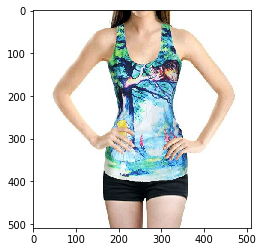

In [2]:
data_dir = "../input/"

img = plt.imread(data_dir + "train/1001.jpg")
imgplot = plt.imshow(img)
plt.show()


In [3]:
top_ten_labels = np.array([66, 105, 153, 17, 171, 106, 222, 214, 53, 62])

labels_file = open(data_dir + 'train/labels.csv', 'r') 
labels = labels_file.readlines()
for i in range(len(labels)):
    labels[i] = np.array(labels[i].split(','))
    labels[i] = labels[i][:228]
    
labels = np.array(labels)
# labels = labels[:,top_ten_labels]

In [4]:
IMAGE_SIZE = 10000
TEST_SIZE = 8000

imgArray=[]

for j in range(1,IMAGE_SIZE+1):
    if j % 1000 == 0:
        print("Finished " + str(j) + " Images")
    imgName = data_dir + 'train/' + str(j) +'.jpg'
    img = im.open(imgName).convert("RGB")
    imgArray.append(np.array(img))
    
    

Finished 1000 Images
Finished 2000 Images
Finished 3000 Images
Finished 4000 Images
Finished 5000 Images
Finished 6000 Images
Finished 7000 Images
Finished 8000 Images
Finished 9000 Images
Finished 10000 Images


In [5]:
X_train = np.array(imgArray[:TEST_SIZE])
y_train = np.array(labels[: TEST_SIZE])

X_test = np.array(imgArray[TEST_SIZE: IMAGE_SIZE])
y_test = np.array(labels[TEST_SIZE:IMAGE_SIZE])

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

print(len(X_train))


Train data shape:  (8000,)
Train labels shape:  (8000,)
8000


In [7]:
import keras
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os
import math

Using TensorFlow backend.


In [8]:
# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    print(X_train.shape)
    big_X_train = np.array([scipy.misc.imresize(X_train[i], (139, 139, 3)) 
                            for i in range(0, len(X_train))]).astype('float32')
    inception_input_train = preprocess_input(big_X_train)
    print(X_train.shape)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
    
print('bottleneck features saved (train)')
print(features.shape)


bottleneck features detected (train)
bottleneck features saved (train)
(8000, 3, 3, 2048)


In [10]:
if os.path.exists('inception_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_X_test = np.array([scipy.misc.imresize(X_test[i], (139, 139, 3)) 
                       for i in range(0, len(X_test))]).astype('float32')
    inception_input_test = preprocess_input(big_X_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features detected (test)
bottleneck features saved (test)


In [11]:
print(features.shape)
print(features.shape[1:])

(8000, 3, 3, 2048)
(3, 3, 2048)


In [25]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

# model = Sequential()
# model.add(Conv2D(filters=30, kernel_size=3, input_shape=features.shape[1:]))
# print(model.output.shape)
# model.add(Dropout(0.4))
# model.add(GlobalMaxPooling2D())
# model.add(Dropout(0.3))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(10, activation='softmax'))
# print(model.output.shape)
# model.summary()

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# checkpointer = ModelCheckpoint(filepath='model.best.hdf5', 
#                                verbose=1, save_best_only=True)
# model.fit(features, y_train, batch_size=50, epochs=50,
#           validation_split=0.1, callbacks=[checkpointer],
#           verbose=2, shuffle=True)


model = Sequential()
model.add(Dense(86, activation='sigmoid', input_shape=features.shape[1:]))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

model.fit(features, y_train)

ValueError: Error when checking target: expected dense_14 to have 4 dimensions, but got array with shape (8000, 1)